# The complete flow of Project Digital Life
This is without the training of the CNN, that can be found in the dir=./sketch_recognition/draw_classification_cnn.ipynb

### Importing packages

In [1]:
# https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/
import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData
from transformers import pipeline
from tensorflow.keras.preprocessing import image_dataset_from_directory
import random

C:\Users\Robert\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model loading

In [2]:
image_size = (28, 28)

# Batch size is a hyperparameter that determines the number of training examples used in one iteration
batch_size = 32 

# The dataset will be split into an 80% training set and a 20% validation set.
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


In [3]:
# Load 
model = tf.keras.models.load_model('./models/model_20230520-222940')

### Testing the model on images from dataset

1/1 [==============================] - 0s 237ms/step
Prediction:  shovel
1/1 [==============================] - 0s 17ms/step
Prediction:  sun
1/1 [==============================] - 0s 17ms/step
Prediction:  bear
1/1 [==============================] - 0s 17ms/step
Prediction:  shark
1/1 [==============================] - 0s 17ms/step
Prediction:  pizza
1/1 [==============================] - 0s 16ms/step
Prediction:  snowman
1/1 [==============================] - 0s 17ms/step
Prediction:  duck
1/1 [==============================] - 0s 18ms/step
Prediction:  rake
1/1 [==============================] - 0s 18ms/step
Prediction:  bottlecap


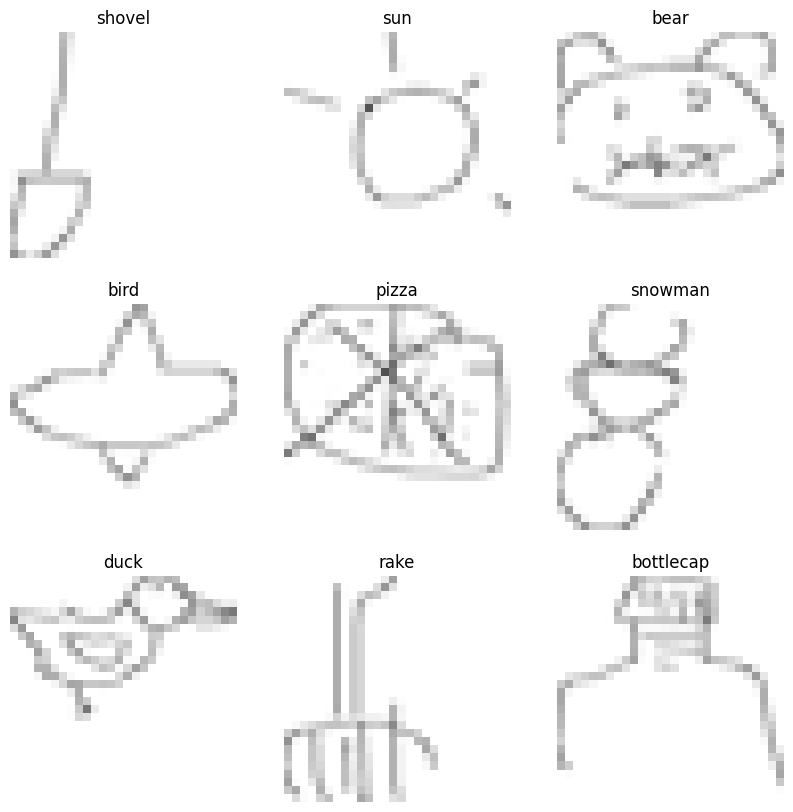

In [4]:
# plot 9 drawings from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

        prediction = model.predict(images[i:i+1])
        print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

1/1 [==============================] - 0s 18ms/step
Prediction:  sheep


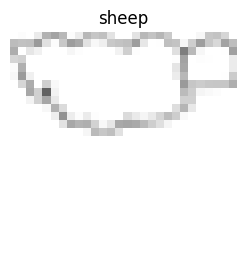

In [5]:
# plot a  drawing from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    ax = plt.subplot(3, 3, 1)
    data = images[0].numpy().astype("uint8")
    plt.imshow(data, cmap='gray', vmin=0, vmax=255)
    plt.title(train_ds.class_names[labels[0]])
    plt.axis("off")

    prediction = model.predict(images[0:1])
    print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

### Recognize human hand drawings 

In [6]:
def increase_brightness(image_path, brightness_factor):
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert the image to RGB mode if it's not already
    image = image.convert("RGB")

    # Create a new blank image with the same size and mode as the original image
    brightened_image = Image.new("RGB", image.size)

    # Iterate over each pixel in the image
    for x in range(image.width):
        for y in range(image.height):
            # Get the pixel value at the current position
            r, g, b = image.getpixel((x, y))

            # Increase the brightness by multiplying each color channel by the brightness factor
            r = min(255, int(r * brightness_factor))
            g = min(255, int(g * brightness_factor))
            b = min(255, int(b * brightness_factor))

            # Set the new pixel value in the brightened image
            brightened_image.putpixel((x, y), (r, g, b))

    # Return the brightened image
    return brightened_image

In [7]:
image_path = "new_drawings/cat.png"
brightness_factor = 1.5 # Adjust the brightness factor as desired

brightened_image = increase_brightness(image_path, brightness_factor)

# Save the brightened image
brightened_image.save("new_drawings/brightened_image.png")

In [8]:
# Open the image
image = Image.open("new_drawings/brightened_image.png")

# Resize the image while maintaining aspect ratio
image.thumbnail((28, 28))

# Create a square image by cropping it from the center
width, height = image.size
size = min(width, height)
left = (width - size) // 2
top = (height - size) // 2
right = (width + size) // 2
bottom = (height + size) // 2
cropped_image = image.crop((left, top, right, bottom))

# Convert the image to grayscale
cropped_image = cropped_image.convert("L")

# Resize the image to 28x28 pixels
cropped_image = cropped_image.resize((28, 28))

# Convert the image to a numpy array
image_array = np.array(cropped_image)

# Reshape the image array to add the channel dimension
image_array = image_array.reshape((1, 28, 28, 1))

# Normalize the image array (optional)
image_array = image_array / 255.0

# Save the preprocessed image
preprocessed_image = Image.fromarray(np.squeeze(image_array * 255).astype(np.uint8))
preprocessed_image.save("new_drawings/preprocessed_image.png")

1/1 [==============================] - 0s 17ms/step
Prediction:  cat


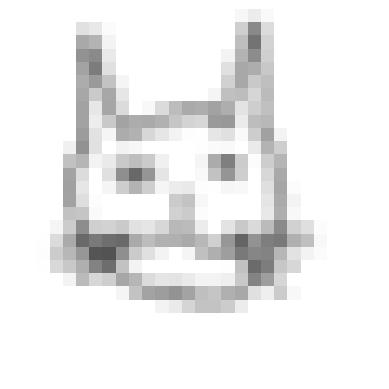

In [9]:
# predict hand drawn image
img = tf.keras.preprocessing.image.load_img(
    "new_drawings/preprocessed_image.png", color_mode="grayscale", target_size=image_size
)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis("off")

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

prediction = model.predict(img_array)
print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

### word vectorization of the predicted drawing

In [20]:
# find synonyms for the predicted word of the hand drawn image
synonym_word = train_ds.class_names[tf.argmax(prediction[0])]
textstr = "Similar words to " + synonym_word + " are: [MASK]."

# print the predicted word
print("Prediction: ", synonym_word)

#create a pipeline for masked language modeling using BERT
bert_model = pipeline('fill-mask', model='bert-base-uncased')

#get synonym predictions for the masked text
synonym_prediction = bert_model(textstr, top_k=15)

#initialize a list to store the filtered words
filtered_words_list = []

#iterate through the synonym predictions
for x in synonym_prediction:
    token_str = x['token_str']

#filter out non-alphabetic tokens
    if token_str.isalpha():
        filtered_words_list.append(token_str)

#print the filtered words with some editing.


filtered_words = [];

# The words to get removed.
withS = synonym_word + 's'
withCapital = synonym_word.capitalize()
withBoth = withS.capitalize()

# Remove words that add an s, or start with a capital letter of the originial word.
# This will only work if its on a seperate loop?!
for t in filtered_words_list:
    if len(t) < 3:
        filtered_words_list.remove(t)

for t in filtered_words_list:
    if t == withCapital:
        filtered_words_list.remove(t)
    if t == synonym_word:
        filtered_words_list.remove(t)

for t in filtered_words_list:
    if t == withS:
        filtered_words_list.remove(t)
    
    if t == withBoth:
        filtered_words_list.remove(t)

# The list of words.
print(filtered_words_list)

Prediction:  cat


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['dog', 'pet', 'rat', 'mouse', 'bat', 'rabbit', 'fox', 'kitten', 'tail', 'tiger', 'animal']


### Image generation

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
rat
10/10 [==============================] - 151s 8s/step
None


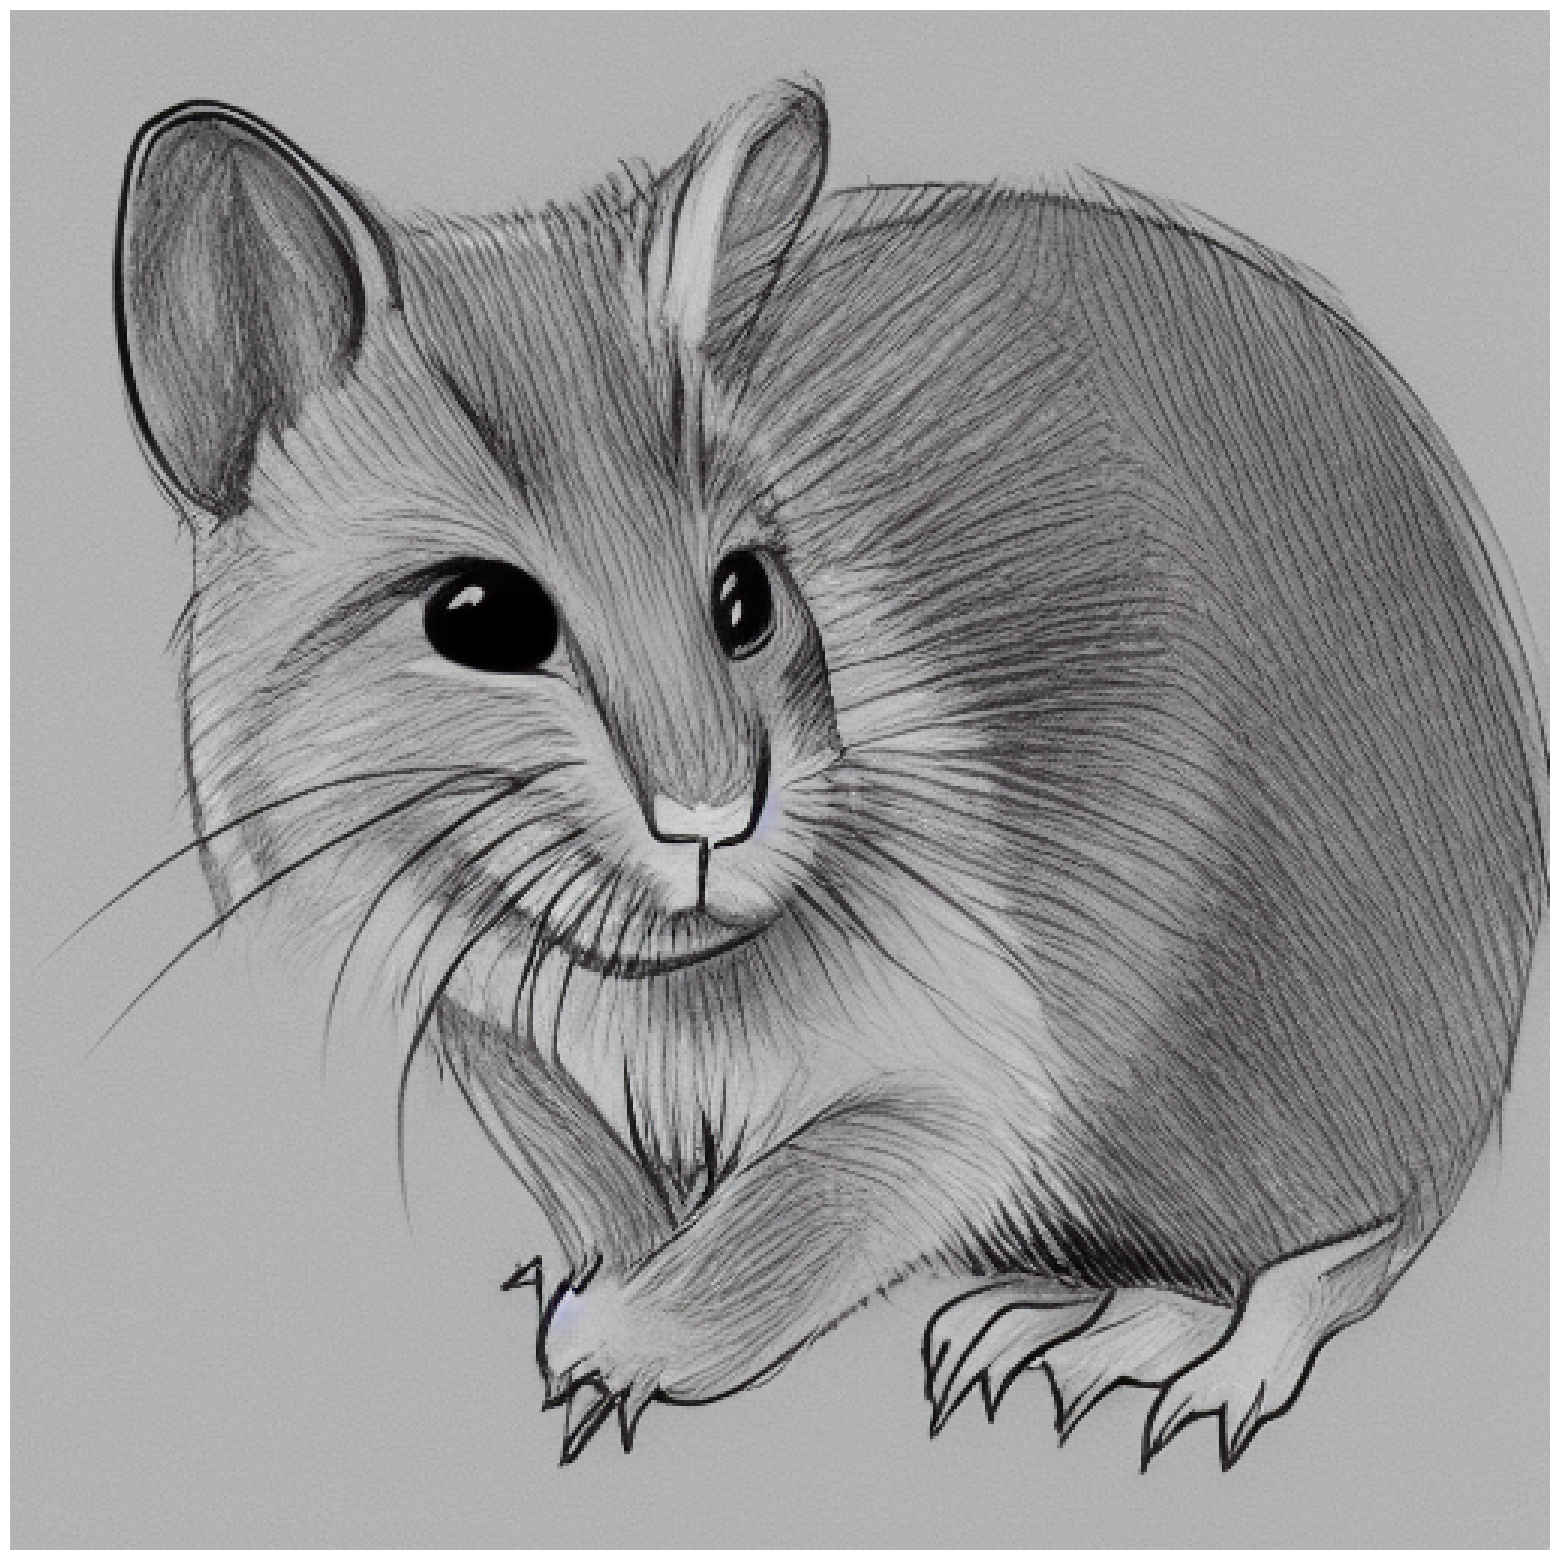

In [22]:
stable_diffusion_model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)

# get a random word from the filtered words list every time the code is run
random_word = random.choice(filtered_words_list)
print(random_word + " " + synonym_word)

prompt = "Generate a sketch with the following characteristics:" + random_word + " " + synonym_word

images = stable_diffusion_model.text_to_image(
    prompt= prompt,
    batch_size=1,  # How many images to generate at once
    num_steps=10,  # Number of iterations (controls image quality)
    seed=123,  # Set this to always get the same image from the same prompt
)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


print(plot_images(images))